In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install -q cupy-cuda12x

In [ ]:
import numpy as np
from scipy.io import wavfile
from IPython.display import Audio
import time
import matplotlib.pyplot as plt

In [ ]:
#dont copy into submission notebook

!ffmpeg -i "/content/All_I_Want_for_Christmas_for_Is_You-Mariah_Carey.wav" \
       -acodec pcm_s16le -ac 1 -ar 44100 \
       "/content/mariah_pcm.wav"

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

## Data Loading

In [ ]:


sr, x = wavfile.read("/mariah_pcm.wav")

if x.ndim == 2:
    x = x.mean(axis=1)

#N = 4096*5
N = 4096 * 64 #multiply by 64 for the dings in the first part

x_segment = x[:N].astype(np.float64)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Audio(x_segment, rate=sr)

## Brute Force DFT Implementation

Forward Discrete Fourier Tranform

$$
X_k=\sum^{N-1}_{n=0} x_n \cdot e^{ - i 2\pi k n / N}
$$

Inverse Discrete Fourier Tranform

$$
x_n = \frac{1}{N} \sum_{k=0}^{N-1} X_k e^{i2 \pi k n / N}
$$

In [ ]:
def DFT_bf(x):
    """Brute-force 1D DFT without building the full N x N matrix."""
    x = np.asarray(x, dtype=np.complex128)
    N = x.shape[0]
    X = np.zeros(N, dtype=np.complex128)
    n = np.arange(N)

    for k in range(N):  #going through each frequency
      X[k] = np.sum(x * np.exp(-2j * np.pi * k * n / N))
    return X

In [ ]:
def inverse_DFT_bf(X):
    X = np.asarray(X, dtype=np.complex128)
    N = X.shape[0]
    x = np.zeros(N, dtype=np.complex128)
    k = np.arange(N)

    for n in range(N):
      x[n] = np.sum(X * np.exp(2j * np.pi * k * n / N))
    return x / N

In [ ]:
%time X_bf = DFT_bf(x_segment)
x_rec = inverse_DFT_bf(X_bf)
x_rec = x_rec.real

CPU times: user 16 s, sys: 95 µs, total: 16 s
Wall time: 16.6 s


In [ ]:
#testing against numpy fft implementation
np.allclose(X_bf, np.fft.fft(x_segment))

True

In [ ]:
x_play = x_rec / np.max(np.abs(x_rec) + 1e-12)
Audio(x_play, rate=sr)

## Recursive Cooley-Tukey

Resource: https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/

$$
X_{N + k} = \sum^{N-1}_{n=0} x_n \cdot e^{ - i 2\pi (N+k) n / N} = \sum^{N-1}_{n=0} x_n \cdot e^{ - i 2\pi n} \cdot e^{ - i 2\pi k n / N} = \sum^{N-1}_{n=0} x_n \cdot e^{ - i 2\pi k n / N}  = X_k
$$

since $e^{ - i 2\pi n} = 1$ for any $n$

Similarly it can be shown $X_{k + i \cdot N} = X_k$

Additionally:

$$
\begin{align*}
X_k &= \sum^{N-1}_{n=0} x_n \cdot e^{ - i 2\pi k n / N} \\
  &= \sum^{N/2-1}_{m=0} x_{2m} \cdot e^{ - i 2\pi k (2m) / N} + \sum^{N/2-1}_{m=0} x_{2m + 1} \cdot e^{ - i 2\pi k (2m + 1) / N} \\
  &= \sum^{N/2-1}_{m=0} x_{2m} \cdot e^{ - i 2\pi k m / (N/2)} + e^{ - i 2 \pi k / N} \sum^{N/2-1}_{m=0} x_{2m+1} \cdot e^{ - i 2\pi k m / (N/2)}
\end{align*}
$$

Since $k$ ranges from 0 to N-1, but m only ranges from 0 to N/2 - 1, we can use what we proved above to calculate $X_k$ for only the bottom half $k$s. We can apply this formulation recursively (as shown below)

In [ ]:
def FFT_recursive(x, cutoff=32):
    """A recursive implementation of the 1D Cooley-Tukey FFT"""
    x = np.asarray(x)
    N = x.shape[0]

    if N % 2 > 0:
        raise ValueError("size of x must be a power of 2")
    elif N <= cutoff:
        return DFT_bf(x)
    else:
        X_even = FFT_recursive(x[::2])
        X_odd = FFT_recursive(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)

        return np.concatenate([X_even + factor[:(N // 2)] * X_odd,
                               X_even + factor[(N // 2):] * X_odd])

In [ ]:
%time X_ct = FFT_recursive(x_segment)
x_rec = np.fft.ifft(X_ct)
x_rec = x_rec.real

CPU times: user 217 ms, sys: 13 µs, total: 217 ms
Wall time: 232 ms


In [ ]:
np.allclose(X_ct, np.fft.fft(x_segment))

True

We can do a similar derivation for the inverse FFT
$$
x_{N + n} = \frac{1}{N}\sum^{N-1}_{k=0} X_k \cdot e^{ i 2\pi (N+n) k / N} = \frac{1}{N} \sum^{N-1}_{k=0} X_k \cdot e^{ i 2\pi k} \cdot e^{ i 2\pi k n / N} \\
= \frac{1}{N} \sum^{N-1}_{k=0} X_k \cdot e^{ i 2\pi k n / N}  = x_n
$$

since $e^{ i 2\pi k} = 1$ for any $k$

Additionally:

$$
\begin{align*}
x_n &= \frac{1}{N} \sum^{N-1}_{k=0} X_k \cdot e^{ i 2\pi k n / N} \\
  &= \frac{1}{N} \left( \sum^{N/2-1}_{m=0} X_{2m} \cdot e^{ i 2\pi n (2m) / N} + \sum^{N/2-1}_{m=0} X_{2m + 1} \cdot e^{ i 2\pi n (2m + 1) / N} \right) \\
  &= \frac{1}{N} \left( \sum^{N/2-1}_{m=0} X_{2m} \cdot e^{ i 2\pi n m / (N/2)} + e^{ i 2 \pi n / N} \sum^{N/2-1}_{m=0} x_{2m+1} \cdot e^{ i 2\pi n m / (N/2)} \right)
\end{align*}
$$

As the same before, we can use what we proved above to calculate $x_n$ for only the bottom half $n$s. We can apply this formulation recursively (as shown below)

In [ ]:
def inverse_helper(X):
  N = X.shape[0]

  if N==1:
    return X

  if N % 2 > 0:
    raise ValueError("size of X msut be a power of 2")
  else:
    x_even = inverse_helper(X[::2])
    x_odd = inverse_helper(X[1::2])
    factor = np.exp(2j * np.pi * np.arange(N) / N)

    return np.concatenate([x_even + factor[:(N // 2)] * x_odd,
                          x_even + factor[(N // 2):] * x_odd])

def inverse_FFT_recursive(X, cutoff=32):
  X = np.asarray(X)
  N = X.shape[0]

  return inverse_helper(X)/N


In [ ]:
np.allclose(x_segment, inverse_FFT_recursive(X_ct))

True

In [ ]:
x_play = x_rec / np.max(np.abs(x_rec) + 1e-12)
Audio(x_play, rate=sr)

In our implementation, we add a cutoff at which point we compute the DFT using our brute force method. This is because every time we recurse, there is extra overhead from the interpreter. This means theres a point at which the consequences from an extra recursion outweigh the savings from the Cooley-Tukey method. We can see this below. While the optimal cutoff value changed over different runs, we saw that 32 appeared the most often.

In [ ]:
cutoff_values = [1, 2, 4, 8, 16, 32, 64, 128]

times = []


for cutoff in cutoff_values:
  time_sum = 0

  for _ in range(3):
    start_time = time.perf_counter()
    _ = FFT_recursive(x_segment, cutoff)
    end_time = time.perf_counter()
    time_sum += (end_time - start_time)

  times.append(time_sum / 3)

min_value = min(times)
cutoff_index = times.index(min_value)
cutoff_value = cutoff_values[cutoff_index]
print("Minimum time achieved with cutoff value ", cutoff_value)

Minimum time achieved with cutoff value  8


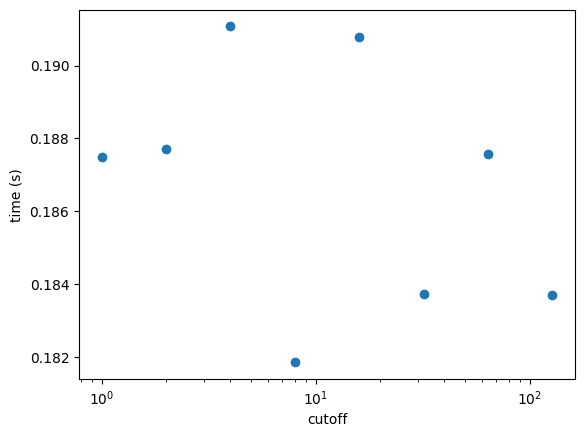

In [ ]:
plt.scatter(cutoff_values, times)
plt.xlabel('cutoff')
plt.xscale('log')
plt.ylabel('time (s)')
plt.show()

**Another implementation using the classic Cooley - Tukey Formulas**


From above we have
$$
\sum^{N/2-1}_{m=0} x_{2m} \cdot e^{ - i 2\pi k m / (N/2)} + e^{ - i 2 \pi k / N} \sum^{N/2-1}_{m=0} x_{2m+1} \cdot e^{ - i 2\pi k m / (N/2)}
$$

Define
$$
\begin{align}
E_k &= \sum_{m=0}^{N/2-1} x_{2m}\, e^{-i 2\pi k m/(N/2)}
\quad\text{(DFT of evens)},\\
O_k &= \sum_{m=0}^{N/2-1} x_{2m+1}\, e^{-i 2\pi k m/(N/2)}
\quad\text{(DFT of odds)},\\
W_N^k &= e^{-i 2\pi k / N}.\\
\end{align}
$$

Then the classic Cooley–Tukey radix-2 FFT formulas are
\[
\begin{aligned}
X_k &= E_k + W_N^k\, O_k,
\qquad k = 0, \dots, N/2 - 1, \\
X_{k+N/2} &= E_k - W_N^k\, O_k,
\qquad k = 0, \dots, N/2 - 1.
\end{aligned}
\]

This follows because
$$
W_N^{k + N/2}
= e^{-i 2\pi (k + N/2)/N}
= e^{-i 2\pi k/N} e^{-i\pi}
= -\, W_N^k.
$$

With these formulas, we are able to get rid of extra computations for the W terms. We implement this set of formulas below. We saw minimal performance gain in practice however.

Recursive Cooley-Tukey without cutoff (Recurses to Base Case N = 0):

*Resource: https://github.com/0xb01u/pyFFT/blob/master/Cooley-Tukey.py*

Reformulated Cooley-Tukey with Cutoff:

In [ ]:
def FFT_recursive(x, cutoff=32):
    """A recursive implementation of the 1D Cooley-Tukey FFT"""
    x = np.asarray(x)
    N = x.shape[0]

    if N % 2 > 0:
        raise ValueError("size of x must be a power of 2")
    elif N <= cutoff:
        return DFT_bf(x)
    else:
        X_even = FFT_recursive(x[::2])
        X_odd = FFT_recursive(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N//2) / N)

        return np.concatenate([X_even + factor * X_odd,
                               X_even - factor * X_odd])

In [ ]:
%timeit X_ct = FFT_recursive(x_segment)
x_rec = np.fft.ifft(X_ct)
x_rec = x_rec.real

208 ms ± 39.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
np.allclose(X_ct, np.fft.fft(x_segment))

True

# Vectorized Cooley Tukey

This implementation is the same as above it just works iteratively rather than with recursion. We are able to eliminate extra overhead from the interpreter for recursion and achieve great performance gains.


Why this works:

We initially start with each column of X having samples C indices apart where N = N_min * C.

Every iteration the spacing gets divided by 2.

The third to last iteation will have the DFT for samples 4 indices apart

The second to last iteration will have the DFT for samples 2 indices apart (aka split into evens and odds).

And the next iteration will build up the DFT for our original list.

This works cuz N_min is a power of 2, so C is a power of 2,

Example:
let x = [x0, x1, x2, x3, x4, x5, x6, x7]

x.reshape(2,4) =
[[x0 x1 x2 x3],
 [x4 x5 x6 x7]]

the first iteration would build the DFTS for [x0,x2,x4,x6] and [x1,x3,x5,x7].




In [ ]:
def FFT_vectorized(x):
    """A vectorized, non-recursive version of the Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]

    if np.log2(N) % 1 > 0:
        raise ValueError("size of x must be a power of 2")

    # N_min here is equivalent to the stopping condition above,
    # and should be a power of 2
    N_min = min(N, 32)

    # O[N^2] Brute Force DFT on all length-N_min sub-problems at once
    n = np.arange(N_min)
    k = n.reshape((N_min, 1))
    M = np.exp(-2j * np.pi * n * k / N_min)  #N_min x N_min matrix
    X = np.dot(M, x.reshape((N_min, -1))) #(N_min x N_min matrix) x (N-min x N/N_min matrix)
    # = (N_min x N/N_min)


    #x.reshape((N_min, -1)) # let N = N_min * C, first_row = first C elements, second row is second C elements, ..
    #each column is a DFT of an N_min block


    # build-up each level of the recursive calculation all at once
    while X.shape[0] < N:
        X_even = X[:, : (X.shape[1] // 2)]
        X_odd = X[:, (X.shape[1] // 2):]
        factor = np.exp(-1j * np.pi * np.arange(X.shape[0])/ X.shape[0])[:, None] #factor is same as before (we just divided out the 2s)


        X = np.vstack([X_even + factor * X_odd,
                       X_even - factor * X_odd])

    return X.ravel() #flatten x (in row major)




In [ ]:
%time X_ct = FFT_vectorized(x_segment)
x_rec = np.fft.ifft(X_ct)
x_rec = x_rec.real

CPU times: user 9.82 ms, sys: 0 ns, total: 9.82 ms
Wall time: 14.5 ms


In [ ]:

%time numpy_fft_ct = np.fft.fft(x_segment)

np.allclose(X_ct, numpy_fft_ct)

CPU times: user 2.19 ms, sys: 0 ns, total: 2.19 ms
Wall time: 1.38 ms


True

# Cooley-Tukey FFT on the GPU

Lets run this on the GPU. CuPy is numpy on the GPU

In [ ]:
import cupy as cp

In [ ]:
sr, x = wavfile.read("/content/mariah_pcm.wav")

if x.ndim == 2:
    x = x.mean(axis=1)


N = [50, 100, 500, 1_000, 5_000, 10_000, 50_000, 100_000, 500_000, 1_000_000]
cpu_times = []
gpu_times = []

for n in N:
  x_segment = x[:n].astype(np.float64)
  start_time = time.perf_counter()
  numpy_fft_ct = np.fft.fft(x_segment)
  end_time = time.perf_counter()
  cpu_times.append(end_time - start_time)

  start_time = time.perf_counter()
  gpu_fft_ct = cp.fft.fft(cp.asarray(x_segment))
  end_time = time.perf_counter()
  gpu_times.append(end_time - start_time)

print(cpu_times)
print(gpu_times)




CUDARuntimeError: cudaErrorInsufficientDriver: CUDA driver version is insufficient for CUDA runtime version

In [ ]:
plt.scatter(N, cpu_times, label="CPU")
plt.scatter(N, gpu_times, label="GPU")

plt.xlabel('data_points')
plt.xscale('log')
plt.ylabel('time (s)')
plt.title('CPU vs GPU')
plt.legend()


plt.show()

## Brute Force GPU Code

In [ ]:
N = 32768

x_segment = x[:N].astype(np.float64)

TODO: insert explanation about how gpu is barely effective at lower execution times, but gets a lot more effective as the data size incerases. this is partially due to dataloading times

In [ ]:
def DFT_bf(x):
    x = cp.asarray(x, dtype=cp.complex128)
    N = x.shape[0]
    X = cp.zeros(N, dtype=cp.complex128)
    n = cp.arange(N)

    for k in range(N):  #going through each frequency

      X[k] = cp.sum(x * np.exp(-2j * np.pi * k * n / N))
    return X

In [ ]:
X_bf = DFT_bf(x_segment)

In [ ]:
np.allclose(X_bf, np.fft.fft(x_segment))

## Vectorized GPU code

In [ ]:
def gpu_FFT_vectorized(x):
    """A vectorized, non-recursive version of the Cooley-Tukey FFT"""
    x = cp.asarray(x, dtype=float)
    N = x.shape[0]

    if cp.log2(N) % 1 > 0:
        raise ValueError("size of x must be a power of 2")

    # N_min here is equivalent to the stopping condition above,
    # and should be a power of 2
    N_min = min(N, 32)

    # O[N^2] Brute Force DFT on all length-N_min sub-problems at once
    n = cp.arange(N_min)
    k = n.reshape((N_min, 1))
    M = cp.exp(-2j * cp.pi * n * k / N_min)  #N_min x N_min matrix
    X = cp.dot(M, x.reshape((N_min, -1))) #(N_min x N_min matrix) x (N-min x N/N_min matrix)
    # = (N_min x N/N_min)


    #x.reshape((N_min, -1)) # let N = N_min * C, first_row = first C elements, second row is second C elements, ..
    #each column is a DFT of an N_min block


    # build-up each level of the recursive calculation all at once
    while X.shape[0] < N:
        X_even = X[:, : (X.shape[1] // 2)]
        X_odd = X[:, (X.shape[1] // 2):]
        factor = cp.exp(-1j * cp.pi * cp.arange(X.shape[0])/ X.shape[0])[:, None] #factor is same as before (we just divided out the 2s)


        X = cp.vstack([X_even + factor * X_odd,
                       X_even - factor * X_odd])

    return X.ravel() #flatten x (in row major)

In [ ]:
%time X_cpu = FFT_vectorized(x_segment)
%time X_gpu = gpu_FFT_vectorized(x_segment)

In [ ]:
np.allclose(X_gpu, np.fft.fft(x_segment))
np.allclose(X_cpu, np.fft.fft(x_segment))

# Extending the FFT beyong powers of 2

---



**Radix-r Cooley-Tukey**

For the Radix-2 Cooley-Tukey, the N-point DFT is repeatedly decomposed into DFTs of size N/2 and recombined with a 2-point butterfly. For Radix-3 and Radix-4, N is factorized by performing calculations N/3 and N/4 respectively, computing three or four sub-DFTs per stage and combining them with 3- or 4-point butterflies. This typically reduces the number of stages from $\log_2(N)$ to $\log_3(N)$ or $\log_4(N)$

**Implementing the Radix-4 Cooley Tukey**

*Resource: https://www.theradixpoint.com/radix4/r4.html*

Assume N is divisible by 4. Each sample index n can be written
$$ 4m + r = n, \ r \in \{0,1,2,3\}$$
$$ X[k] = \sum^{3}_{r=0} \sum^{N/4 - 1}_{m= 0 } x[4m+r] W^{k(4m+r)}_N $$
$$ X[k] = \sum^{3}_{r=0} W^{rk}_N \sum^{N/4 - 1}_{m= 0 } x[4m+r] W^{k*4m}_N $$

Since
$$ W^{4k}_N = (e^{-i 2 \pi / N})^{4k} = e^{-i 2 \pi k / (N/4)} = W^{k}_{N/4}$$
The above equation can be rewritten as
$$ X[k] = \sum^{3}_{r=0} W^{rk}_N \sum^{N/4 - 1}_{m= 0 } x[4m+r] W^{k*m}_{N/4} $$

Define
$$A[k] = \sum^{N/4 - 1}_{m= 0 } x[4m] W^{k*m}_{N/4} $$
$$B[k] = \sum^{N/4 - 1}_{m= 0 } x[4m+1] W^{k*m}_{N/4} $$
$$C[k] = \sum^{N/4 - 1}_{m= 0 } x[4m+2] W^{k*m}_{N/4} $$
$$D[k] = \sum^{N/4 - 1}_{m= 0 } x[4m+3] W^{k*m}_{N/4} $$

$$X[k] = A[k] + W^k_N B[k] + W^{2k}_N C[k] + W^{3k}_N D[k] $$

Effectively, the original problem is split into four smaller FFTs of size N/4 and they are recombined with twiddle factors. This decomposition can be applied repeatedly across $\log_4(N)$ stages.

In [ ]:
def fft4_core(x):
  """
  Compute 1D FFT of x using the radix-4 Cooley-Tukey algorithm.

  Note: This implementation requires N be an exact power of 4

  Parameters
  ----------
  x: array-like with length power of four
    Real or complex input samples

  Returns
  -------
  X: array of complex FFT coefficients
  """

  x = np.asarray(x, dtype = np.complex128).copy()
  N = x.size

  #Calculate number of radix-4 stages
  s = int(round(np.log(N) / np.log(4)))
  if not power_of_four_check(N):
    raise ValueError("Size of x must be a power of 4")

  #Build table of twiddle factors
  W = np.exp(-2j * np.pi * np.arange(N) / N)

  stage_size = 4 #number of DFT blocks built at each stage

  for stage in range(s):
    quarter = stage_size // 4

    for block in range(0, N, stage_size):

      for j in range(quarter):
        a = block + j
        b = a + quarter
        c = a + 2*quarter
        d = a + 3*quarter

        stride = N // stage_size

        if j==0:
          tb = x[b]
          tc = x[c]
          td = x[d]
        else:
          tb = x[b] * W[j*stride]
          tc = x[c] * W[2*j*stride]
          td = x[d] * W[3*j*stride]

        ta = x[a]

        #4-pt DFT combine

        e = ta + tc
        f = ta - tc
        g = tb + td
        h = tb - td
        jh = 1j * h

        x[a] = e + g
        x[b] = f - jh
        x[c] = -g + e
        x[d] = jh + f

    stage_size *= 4

  return x

def power_of_four_check(N: int) -> bool:
  while N % 4 == 0 and N > 1:
    N //= 4
  return N==1

def invfft4(X):
  """
  Compute the inverse FFT corresponding to fft4 using the
  identity
  ifft(X) = conj(fft(conj(X))) / N

  Parameters
  __________
  x: array-like
    complex frequency domain coefficients

  Returns
  _________
  X: array of real time domain samples (normalized inverse FFT)
  """
  X = np.asarray(X, dtype = np.complex128)
  N = X.size

  x = np.conjugate(fft4(np.conjugate(X))) / N
  return x

To ensure the inverse reconstructs the original time sequence, we have to perform digit reversal. Without the digit reversal, the iterative radix-4 butterflies combine samples in the order required by the Cooley-Tukey stage layout rather than the natural input order. Thus, when the inverse is taken, it will be permuted and the reconstructed audio would sound different than the input.

In [ ]:
def fft4(x):
  x= np.asarray(x, dtype = np.complex128)
  N = x.size
  perm = digit_reverse(N)
  return fft4_core(x[perm])


def digit_reverse(N):
  """
  Generates array of base-4 digit reversal permutation indices for N = 4^s
  """

  s = int(round(np.log(N)/ np.log(4)))
  if 4**s != N:
    raise ValueError("N must be a power of 4")
  idx = np.arange(N)
  out = np.zeros(N, dtype = int)
  for i in range(s):
    out = out * 4 + (idx % 4)
    idx = idx // 4
  return out

In [ ]:
X_CT4 = fft4(x_segment)
x_rec_CT4 = invfft4(X_CT4)
Audio(np.real(x_rec_CT4), rate=sr)

In [ ]:
np.allclose(X_CT4, np.fft.fft(x_segment))

True

**Mixed-Radix FFT**

*Resource: https://dsp-book.narod.ru/FFTBB/0270_PDF_C12.pdf*

Assume N = rm. Each sample index n can be written as
$$ n = rq + p, \ p \in \{0,1,..., r-1\}, \ r \in \{0,1,...,m-1)\}$$

$$ X[k] = \sum^{r-1}_{p=0} \sum^{m-1}_{q= 0 } x[rq + p] W^{k(rq+p)}_N $$
$$ X[k] = \sum^{r-1}_{p=0} W^{kp}_N \sum^{m-1}_{q= 0 } x[rq + p] W^{krq}_N $$
$$N = rm$$
Define
$$Y_p[k] = \sum^{m-1}_{q= 0 } x[rq + p] W^{kq}_m \ (p = 0, ..., r-1) $$

Thus
$$X[k] = \sum^{r-1}_{p=0} W^{kp}_N Y_p[k]$$

Overall, r sub-FFTs of length m are computed, then multiplied by twiddle factors, and recombined in an r-point DFT.

Applying a mixed-radix FFT is useful because it extends Cooley-Tukey to lengths N that are not perfect powers of 2 or 4. Instead, N can be factorized into small radices and a different radix can be applied at each stage. This can be more efficient than padding to the next power of 2 when N already has small factors. While our radix-2 and radix-4 FFT implementations are written specifically for powers of 2 and 4, padding can be a valid workaround, but it changes the FFT length and therefore the frequency sampling grid. In contrast, the mixed-radix FFT computes the DFT at the original length N, preserving the intended frequency resolution and avoiding any padding-induced changes.

In [ ]:
def fft_mixed(x):
  """
  Compute the 1D FFT of x using a mixed-radix Cooley-Tukey FFT

  This implementation recursively factorizes the transform length N
  into N = r*m where r is chosen from {4, 2, 3, 5}
  If there are no factors in this range, the function applies the brute
  force DFT.

  Parameters
  ----------
  x: array-like
    Real or complex input samples

  Returns
  -------
  X: array of complex FFT coefficients
  """

  x = np.asarray(x, dtype = np.complex128)
  N = x.size
  if N == 1:
    return x.copy()

  #choose radix factor
  r = None
  for factor in (4,2,3,5):
    if N % factor == 0:
      r = factor
      break

  if r is None:
    return DFT_bf(x)

  m = N // r

  # construct sub-FFTs of size m
  Y = np.empty((r,m), dtype = np.complex128)
  for i in range(r):
    Y[i, :] = fft_mixed(x[i::r])

  #adjust with twiddle factor
  p = np.arange(r)[:, None]
  q = np.arange(m)[None, :]
  Y *= np.exp(-2j * np.pi * (p*q) / N)

  #combine
  X = np.empty(N, dtype = np.complex128)
  for q_idx in range(m):
    X[q_idx::m] = DFT_small(Y[:, q_idx])

  return X

def ifft_mixed(X):
  """
  Compute the inverse FFT corresponding to fft_mixed using the
  identity
  ifft(X) = conj(fft_mixed(conj(X))) / N

  Parameters
  ----------
  x: array-like
    complex frequency domain coefficients

  Returns
  --------
  X: array of real time domain samples (normalized inverse FFT)
  """
  X = np.asarray(X, dtype = np.complex128)
  x = np.conjugate(fft_mixed(np.conjugate(X)))
  return x/ X.size

In [ ]:
def DFT_small(x):
  """
  Compute length-r DFT using a direct DFT matrix

  Parameters
  ----------
  x: array-like
    Real or complex input samples

  Returns
  -------
  X: array of complex DFT coefficients
  """
  x = np.asarray(x, dtype = np.complex128)
  r = x.size
  n = np.arange(r)
  k = n[:, None]
  M = np.exp(-2j * np.pi * k * n / r)
  return M.dot(x)

In [ ]:
%time X_CT5 = fft_mixed(x_segment)
x_rec_CT5 = ifft_mixed(X_CT5)
Audio(np.real(x_rec_CT5), rate=sr)

CPU times: user 383 ms, sys: 1.47 ms, total: 384 ms
Wall time: 393 ms


In [ ]:
np.allclose(X_CT5, np.fft.fft(x_segment))

True

## Handling Arbitrary-Length FFTs

**Bluestein's Algorithm**

*Resource: https://github.com/nirnaim/fft-bluestein-python/blob/main/fft.bluestein.ipynb*

Bluestein's algorithm can be employed when N is a "bad" size for Cooley-Tukey. This occurs if N is prime, or has large prime factors. In this case, radix-2, radix-4, or mixed-radix approaches cannot be used to factor it in small stages.

Instead of factoring N, Blustein's algorithm rewrites the DFT as a convolution and then computes that convolution with a convenient power of two FFT.

This gives an O(NlogN) FFT for any value of N.

Starting from the DFT, we use Blustein's identity to rewrite $W^{kn}_N$.

Bluesten's identity: $$kn = \frac{1}{2} (k^2 + n^2 - (k-n)^2)$$
so

$$ W^{kn}_N = e^{-i \frac{2 \pi}{N} kn }$$
$$ W^{kn}_N = e^{-i \frac{\pi}{N}k^2}e^{ -i \frac{\pi}{N}n^2 } e^{i \frac{\pi}{N}(k-n)^2 }$$
Thus
$$X[k] = e^{-i \frac{\pi}{N}k^2}\sum^{N-1}_{n=0} (x[n] e^{ -i \frac{\pi}{N}n^2 })e^{i \frac{\pi}{N}(k-n)^2 }$$

define
$$a[n] = x[n]e^{ -i \frac{\pi}{N}n^2 }$$
$$b[m] = e^{i \frac{\pi}{N}m^2}$$
in the above summation, m = k-n, so
$$X[k] = e^{-i \frac{\pi}{N}k^2}\sum^{N-1}_{n=0} a[n] b[k-n]$$
The inner sum is a discrete convolution (a*b)[k], so the DFT can be rewritten
$$X[k] = e^{-i \frac{\pi}{N}k^2} (a*b)[k], \ a[n] = x[n]e^{ -i \frac{\pi}{N}n^2 }, \ b[m] = e^{i \frac{\pi}{N}m^2}$$

The DFT reduces to a linear convolution of two length N sequences, whose full result lives on 2N-1 indices. Thus, both sequences a and b are padded up to length M $\geq$ 2N-1. Their convolution is then computed by taking the FFT of each padded array, multiplying them pointwise, and applying an inverse FFT. The first N samples of this convolution, after the final chirp multiplication, give the desired DFT values.

In [ ]:
def fft_blue(vec, inverse = False, fft_pow2 = None):
  """
  Compute length-N DFT using Bluestein's algorithm.

  This method works for arbitrary N by rewriting the DFT as a linear
  convolution of two chirp-modulated sequences, and then computing
  this convolution with a power of two FFT.

  Parameters
  -----------
  vec: array_like
    input samples
  inverse: bool
    if False, compute the forward DFT of vec
    if True, compute the inverse DFT
  fft_pow2: function implementing a power of two FFT
    if None, defaults to our earlier recursive Radix 2 function

  Returns
  -------
  X: array of complex DFT coefficients

  """

  x = np.asarray(x, dtype = np.complex128)
  N = x.size
  if N <= 1:
    return x.copy()

  if fft_pow2 is None:
    def fft_pow2(a, inverse=False):
      return inverse_FFT_recursive(a) if inverse else FFT_recursive(a)

  #pad to next power of two length for convolution
  M = next_pow2(2 * N - 1)
  sgn = +1 if inverse else -1

  n = np.arange(N)
  chirp = np.exp(sgn * 1j * np.pi * (n*n) /N)

  a = x * np.conjugate(chirp)

  #build b as chirp with mirrored tail, padded to length M
  b = np.zeros(M, dtype = np.complex128)
  b[:N] = chirp
  b[M - (N-1)] = chirp[1:][::-1]

  #pad a to length M
  A = np.zeros(M, dtype = np.complex128)

  A[:N] = a

  conv = conv(A, b, fft_pow2)
  #take first N terms and undo chirp
  X = conv[:N] * np.conjugate(chirp)

  if inverse:
    X = X/N
  return X

def conv(a, b, fft_pow2):
  """
  Compute the linear convolution of two sequences.

  Both inputs must be zero-padded to the same length M (power of 2)

  Parameters
  ----------
  a, b: array_like (same length)
    input sequences to convolve
  fft_pow2: callable
    power of two FFT function

  Returns
  -------
  c: circular convolution of a and b with the same length as the inputs
  """
  Fa = fft_pow2(a, inverse = False)
  Fb = fft_pow2(b, inverse = False)
  return fft_pow2(Fa * Fb, inverse = True)

def next_pow(n: int) -> int:
  """
  Returns the smallest power of two greater than or equal to n

  Parameters
  ----------
  n : positive integer

  Returns
  -------
  m: smallest power of two such that m >= n
  """
  return 1 << (n-1).bit_length()

## Running Numpy FFT

In [ ]:
%time X_np = np.fft.fft(x_segment)
x_rec = np.fft.ifft(X_np)
x_rec = x_rec.real

In [ ]:
x_play = x_rec / np.max(np.abs(x_rec) + 1e-12)
Audio(x_play, rate=sr)